In [2]:
import numpy as np
import scipy.linalg as sla
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import time
import shelve
%matplotlib notebook
%load_ext line_profiler
%load_ext memory_profiler
%load_ext cython

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [3]:
class BandedMatrix(spla.LinearOperator):
    
    def __init__(self, shape, dtype, L, U):
        self.shape = shape
        self.dtype = dtype
        self.L = L
        self.U = U
        self.data = np.zeros((U+L+1, shape[1]), dtype=dtype, order='F')
    
    @classmethod
    def from_sparse(cls, A):
        # Convert to sparse DIA format
        Ad = sp.dia_matrix(A)
        # Build banded matrix
        U = max(0, max(Ad.offsets))
        L = max(0, max(-Ad.offsets))
        Ab = cls(Ad.shape, Ad.dtype, L, U)
        # Copy data
        Ab.data[U-Ad.offsets] = Ad.data
        return Ab
        
    def todia(self):
        offsets = np.arange(-self.L, self.U+1)[::-1]
        Ad = sp.dia_matrix((self.data, offsets), shape=self.shape)
        return Ad
    
    def copy(self):
        copy = type(self)(self.shape, self.dtype, self.L, self.U)
        np.copyto(copy.data, self.data)
        return copy
    
    def _matvec(self, v):
        v = v.ravel()
        I, J = self.shape
        U, L = self.U, self.L
        # Allocate output
        dtype = np.promote_types(self.dtype, v.dtype)
        out = np.zeros(I, dtype=dtype)
        # Compute output
        for j in range(J):
            i0 = max(0, j-U)
            i1 = min(J, j+L+1)
            out[i0:i1] += self.data[i0+U-j:i1+U-j, j] * v[j]
        return out
    
    def _adjoint(self):
        return type(self).from_sparse(self.todia().H)
    
def random_banded_real(I, J, L, U):
    data = np.random.rand(L+U+1, J) - 0.5
    offsets = np.arange(-L, U+1)
    data[:] += 1
    A_dia = sp.dia_matrix((data, offsets), shape=(I, J))
    A_ban = BandedMatrix.from_sparse(A_dia)
    return A_ban

def random_banded_complex(I, J, L, U):
    data = np.random.rand(L+U+1, J) + 1j*np.random.rand(L+U+1, J) - (0.5 + 0.5j)
    offsets = np.arange(-L, U+1)
    data[:] += 1
    A_dia = sp.dia_matrix((data, offsets), shape=(I, J))
    A_ban = BandedMatrix.from_sparse(A_dia)
    return A_ban

In [4]:
class BandedQ(spla.LinearOperator):
    
    def __init__(self, shape, dtype, M, N):
        self.shape = shape
        self.dtype = dtype
        self.M = M
        self.N = N
        self.data = np.zeros((M, N), dtype=dtype, order='F')
        
    def copy(self):
        copy = type(self)(self.shape, self.dtype, self.N)
        np.copyto(copy.data, self.data)
        return copy

    def _matvec(self, v):
        v = v.ravel().astype(self.dtype)
        I, J = self.shape
        M, N = self.M, self.N
        # Allocate output
        out = np.zeros(I, dtype=self.dtype)
        # Apply kernel
        banded_q_matvec_kernel(self.data, v, out, I, J, M, N)
        return out
        
    def _rmatvec(self, v):
        v = v.ravel().astype(self.dtype)
        I, J = self.shape
        M, N = self.M, self.N
        # Allocate output
        out = np.zeros(I, dtype=self.dtype)
        # Apply kernel
        banded_q_rmatvec_kernel(self.data, v, out, I, J, M, N)
        return out

In [180]:
class BandedQR:
    
    def __init__(self, A):
        self.Q, self.R = self.factorize(A)

    @staticmethod
    def factorize(self, A):
        # Check shape
        m, n = A.shape
        if m < n:
            raise ValueError("Matrix must have at least as many rows as columns.")
        # Copy A to scratch R matrix with expanded storage
        R = BandedMatrix(A.shape, A.dtype, A.L, A.U+A.L)
        R.data[A.L:, :] = A.data
        # Local references
        RU = R.U
        RL = R.L
        M = RL + 1
        N = min(m-1, n)
        # Create matrix for compressed Q
        W = np.zeros((M, N), dtype=R.dtype, order='F')

        qr_banded_kernel(R.data, W, M, N, m, n, RU)

        # Return R without extra scratch space
        Rn = BandedMatrix(R.shape, R.dtype, L=0, U=RU)
        Rn.data[:] = R.data[:RU+1]
        # Build banded Q
        Q = BandedQ((m, m), A.dtype, M, N)
        np.copyto(Q.data, W)
        return Q, Rn
    
    def solve(self, b):
        QHb = self.QH @ b
        R = self.R
        x = sla.solve_banded((R.L, R.U), R.data, QHb)
        return x

In [166]:
tests = []
def add_test(test):
    tests.append(test)
    return test

def test_QR_scipy(A_banded):
    Q, R = qr_banded(A_banded)
    Qs, Rs = sla.qr(A_banded.todia().A)
    v1 = R.todia().A
    v2 = Rs
    return np.allclose(v1, v2), np.max(np.abs(v1 - v2))

@add_test
def test_QR_recomposition(A_banded):
    Q, R = qr_banded(A_banded)
    v1 = A_banded.todia().A
    v2 = Q @ R.todia().A
    return np.allclose(v1, v2), np.max(np.abs(v1 - v2))

@add_test
def test_QR_mul(A_banded):
    J = A_banded.shape[1]
    x = np.random.rand(J) + 1j*np.random.rand(J) - (0.5 + 0.5j)
    b = A_banded @ x
    Q, R = qr_banded(A_banded)
    v1 = b
    v2 = Q @ R @ x
    return np.allclose(v1, v2), np.max(np.abs(v1 - v2))

@add_test
def test_QR_mulH(A_banded):
    J = A_banded.shape[1]
    x = np.random.rand(J) + 1j*np.random.rand(J) - (0.5 + 0.5j)
    b = A_banded.H @ x
    Q, R = qr_banded(A_banded)
    v1 = b
    v2 = R.H @ Q.H @ x
    return np.allclose(v1, v2), np.max(np.abs(v1 - v2))

@add_test
def test_Q_mul(A_banded):
    J = A_banded.shape[1]
    x = np.random.rand(J) + 1j*np.random.rand(J) - (0.5 + 0.5j)
    b = A_banded.H @ x
    Q, R = qr_banded(A_banded)
    v1 = (Q@np.identity(Q.shape[1])) @ x
    v2 = Q @ x
    return np.allclose(v1, v2), np.max(np.abs(v1 - v2))

@add_test
def test_Q_mulH(A_banded):
    J = A_banded.shape[1]
    x = np.random.rand(J) + 1j*np.random.rand(J) - (0.5 + 0.5j)
    b = A_banded.H @ x
    Q, R = qr_banded(A_banded)
    v1 = np.conj((Q@np.identity(Q.shape[1])).T) @ x
    v2 = Q.H @ x
    return np.allclose(v1, v2), np.max(np.abs(v1 - v2))

@add_test
def test_QR_solve(A_banded):
    J = A_banded.shape[1]
    x = np.random.rand(J) + 1j*np.random.rand(J) - (0.5 + 0.5j)
    b = A_banded @ x
    Q, R = qr_banded(A_banded)
    v1 = x
    v2 = solve_qr(Q, R, b)
    return np.allclose(v1, v2), np.max(np.abs(v1 - v2))

@add_test
def test_R_solve(A_banded):
    J = A_banded.shape[1]
    x = np.random.rand(J) + 1j*np.random.rand(J) - (0.5 + 0.5j)
    Q, R = qr_banded(A_banded)
    c = R @ x
    v1 = x
    v2 = sla.solve_banded((R.L, R.U), R.data, c)
    return np.allclose(v1, v2), np.max(np.abs(v1 - v2))

In [7]:
%%cython -a -f
# cython: profile=True

import numpy as np
cimport cython

# Create fused type for double precision real and complex
ctypedef fused double_rc:
    double
    double complex
   
@cython.cdivision(True)
cdef double_rc csign(double_rc x):
    if x == 0:
        return 1
    else:
        return x / abs(x)

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef qr_banded_kernel(double_rc[::1,:] R, 
                       double_rc[::1,:] Q, 
                       int M, 
                       int N, 
                       int m, 
                       int n, 
                       int RU):
    # Allocate indeces
    cdef int j, p, di, k, xi
    # Allocate scratch variables
    cdef double sr
    cdef double_rc src, x0, u0
    # Loop over columns
    for j in range(N):
        # Determine number of rows including+below diagonal
        p = M - max(0, j - (m-M))
        # Compute norm(x)
        x0 = R[RU, j]
        sr = abs(x0)**2
        for di in range(1, p):
            sr = sr + abs(R[RU+di, j])**2
        src = sr**0.5
        # Compute first index of Householder vector
        u0 = x0 + src * csign(x0)
        # Normalize Householder vector
        sr = sr + abs(u0)**2 - abs(x0)**2
        src = sr**(-0.5)
        Q[0, j] = u0 * src
        for di in range(1, p):
            Q[di, j] = R[RU+di, j] * src
        # Apply reflection to remainder of R
        for k in range(j, min(j+1+RU, n)):
            xi = RU-(k-j)
            # Compute v.x
            src = 0
            for di in range(p):
                src = src + Q[di, j].conjugate() * R[xi+di, k]
            # Apply reflection to x
            for di in range(p):
                R[xi+di, k] = R[xi+di, k] - 2 * src * Q[di, j]
             
@cython.boundscheck(False)
@cython.wraparound(False)
cpdef banded_q_matvec_kernel(double_rc[::1, :] Q,
                             double_rc[:] a,
                             double_rc[:] b,
                             int I,
                             int J,
                             int M,
                             int N):
    # Allocate indeces
    cdef int j, p, di
    # Allocate scratch variables
    cdef double_rc src
    # Copy a to b
    for j in range(J):
        b[j] = a[j]
    # Compute output
    for j in reversed(range(N)):
        p = M - max(0, j - (I-M))
        # Compute v.x
        src = 0
        for di in range(p):
            src = src + Q[di, j].conjugate() * b[j+di]
        # Apply reflection to x
        for di in range(p):
            b[j+di] = b[j+di] - 2 * src * Q[di, j]
            
@cython.boundscheck(False)
@cython.wraparound(False)
cpdef banded_q_rmatvec_kernel(double_rc[::1, :] Q,
                             double_rc[:] a,
                             double_rc[:] b,
                             int I,
                             int J,
                             int M,
                             int N):
    # Allocate indeces
    cdef int j, p, di
    # Allocate scratch variables
    cdef double_rc src
    # Copy a to b
    for j in range(J):
        b[j] = a[j]
    # Compute output
    for j in range(N):
        p = M - max(0, j - (I-M))
        # Compute v.x
        src = 0
        for di in range(p):
            src = src + Q[di, j].conjugate() * b[j+di]
        # Apply reflection to x
        for di in range(p):
            b[j+di] = b[j+di] - 2 * src * Q[di, j]
            
        

In [167]:
I = J = 128
for U in range(4):
    for L in range(4):
        Ab = random_banded_complex(I, J, L, U)
        print(U, L, np.linalg.cond(Ab.todia().A))
        for test in tests:
            print(*test(Ab))
        print()

0 0 3.002509217957954
True 2.7012892057857038e-15
True 1.4475537224895361e-15
True 1.7342238036525468e-15
True 2.7755575615628914e-16
True 2.7755575615628914e-16
True 2.482534153247273e-16
True 1.1102230246251565e-16

0 1 962.5592628453588
True 1.3463600052204709e-15
True 1.0429598422709816e-15
True 1.0605390551611693e-15
True 5.117875266520903e-16
True 2.607399605677454e-16
True 2.663359377537551e-13
True 2.142759199588038e-15

0 2 45833205.81637206
True 1.1443916996305594e-15
True 8.95090418262362e-16
True 1.319485001705613e-15
True 5.79553433516819e-16
True 1.2914547347233453e-15
True 3.1516142028639037e-09
True 9.995861419348e-16

0 3 13673148.070837509
True 1.3877787807814457e-15
True 2.110154030260182e-15
True 1.27675647831893e-15
True 6.335327934766281e-16
True 5.211566658954003e-16
True 1.7505042100352082e-09
True 2.0206364052201327e-15

1 0 2539.6067240835323
True 2.8457249041605285e-15
True 1.9641850382783467e-15
True 1.6504651808933464e-15
True 2.2887833992611187e-16
True 3.

In [168]:
I = J = 8192
BW = 2**np.arange(2, 8)
for bw in BW:
    print('Bandwidth:', bw)
    L = U = bw//2
    Ab = random_banded_complex(I, J, L, U)
    A_csc = Ab.todia().tocsc()
    # Time factorization
    print('Factorization:')
    %timeit qr_banded(Ab)
    %timeit spla.splu(A_csc, permc_spec="NATURAL")
    # Time solve
    Q, R = qr_banded(Ab)
    LU = spla.splu(A_csc, permc_spec="NATURAL")
    b = np.random.rand(J) + 1j*np.random.rand(J)
    print('Solve:')
    %timeit solve_qr(Q, R, b)
    %timeit LU.solve(b)
    print()

Bandwidth: 4
Factorization:
1.68 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
10.8 ms ± 665 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Solve:
993 µs ± 129 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
404 µs ± 42.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Bandwidth: 8
Factorization:
2.48 ms ± 229 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.63 ms ± 281 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Solve:
1.37 ms ± 14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
454 µs ± 6.65 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Bandwidth: 16
Factorization:
5.58 ms ± 91.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.2 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Solve:
2.24 ms ± 44.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
636 µs ± 14.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Bandwidth: 32
Factorization:
18 m

In [9]:
tqr = [1.58, 2.65, 6.76, 19.1, 67.8, 222]
tlu = [10.2, 10.8, 23.1, 52.6, 131, 408]

<IPython.core.display.Javascript object>


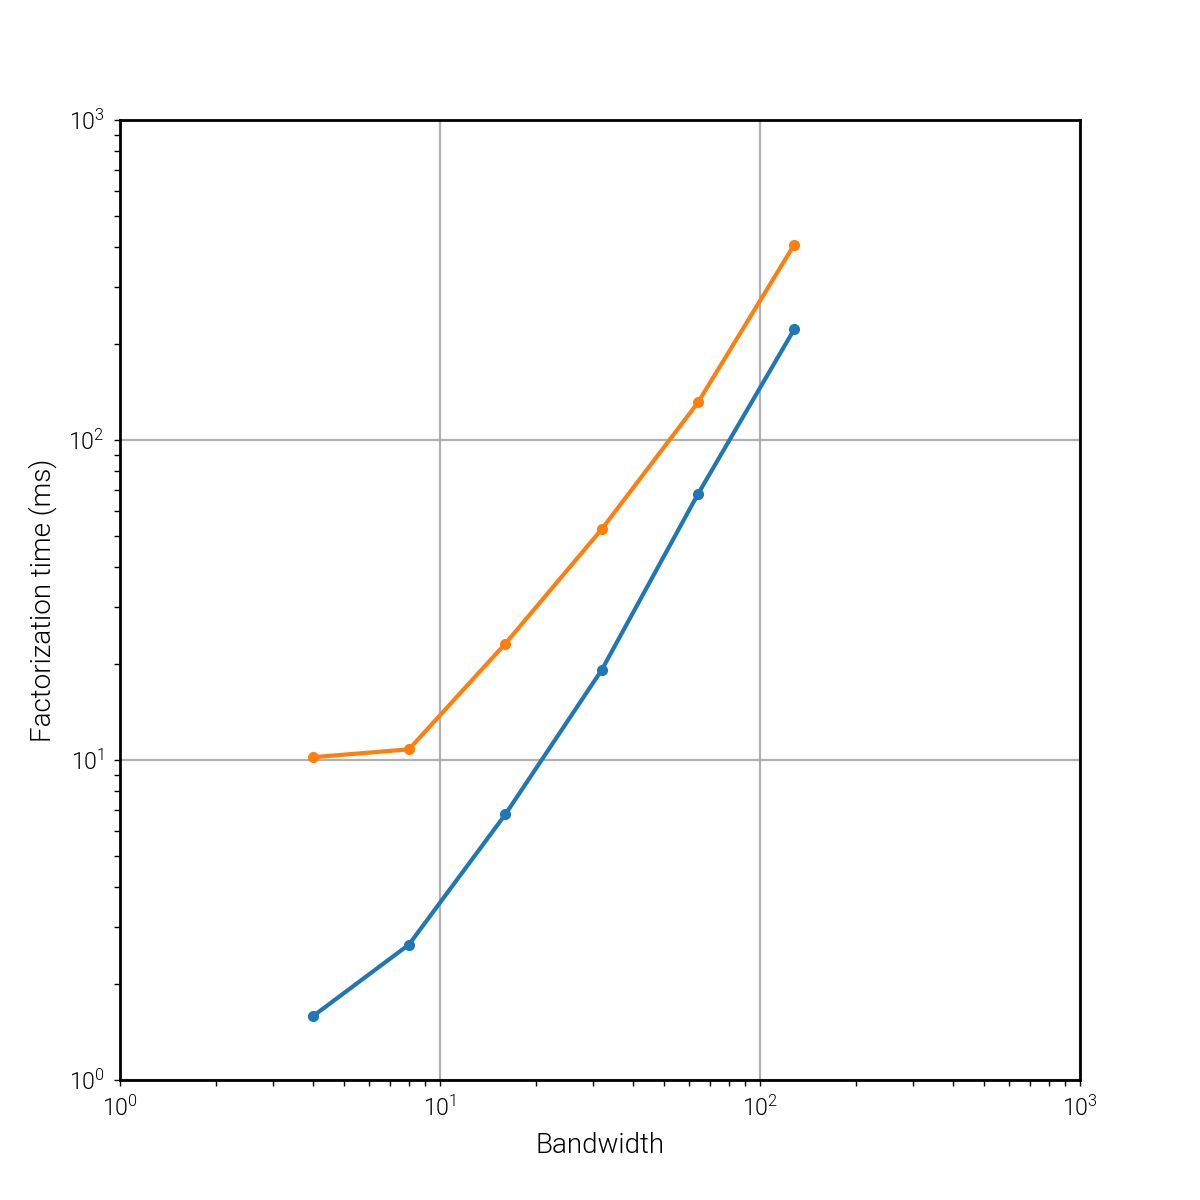

In [20]:
plt.figure(figsize=(6,6))
plt.loglog(BW, tqr, '.-')
plt.loglog(BW, tlu, '.-')
plt.xlim([1,10**3])
plt.ylim([1,10**3])
plt.xlabel('Bandwidth')
plt.ylabel('Factorization time (ms)')
plt.grid()

In [24]:
matrices = shelve.open("matrices.dat", "r")
matrices['LHS']

[<112x112 sparse matrix of type '<class 'numpy.complex128'>'
 	with 716 stored elements in Compressed Sparse Row format>,
 <224x224 sparse matrix of type '<class 'numpy.complex128'>'
 	with 1658 stored elements in Compressed Sparse Row format>,
 <448x448 sparse matrix of type '<class 'numpy.complex128'>'
 	with 3546 stored elements in Compressed Sparse Row format>,
 <896x896 sparse matrix of type '<class 'numpy.complex128'>'
 	with 7322 stored elements in Compressed Sparse Row format>,
 <1792x1792 sparse matrix of type '<class 'numpy.complex128'>'
 	with 14874 stored elements in Compressed Sparse Row format>,
 <3584x3584 sparse matrix of type '<class 'numpy.complex128'>'
 	with 29978 stored elements in Compressed Sparse Row format>,
 <7168x7168 sparse matrix of type '<class 'numpy.complex128'>'
 	with 60186 stored elements in Compressed Sparse Row format>,
 <14336x14336 sparse matrix of type '<class 'numpy.complex128'>'
 	with 120602 stored elements in Compressed Sparse Row format>]

In [169]:
index = -2
A_csr = matrices['LHS'][index]
b = matrices['RHS'][index]
A_csc = A_csr.tocsc()
A_ban = BandedMatrix.from_sparse(A_csr)

In [170]:
%timeit qr_banded(A_ban)
%timeit spla.splu(A_csc, permc_spec="NATURAL")

508 ms ± 6.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
32.9 ms ± 800 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [171]:
Q, R = qr_banded(A_ban)
LU = spla.splu(A_csc, permc_spec="NATURAL")

%timeit solve_qr(Q, R, b)
%timeit LU.solve(b)

40.7 ms ± 725 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.21 ms ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
%prun solve_qr(Q, R, b)

In [ ]:
%memit qr_banded(A_ban)

In [ ]:
%memit LU = spla.splu(A_csc, permc_spec="NATURAL")
%memit LU.solve(b)

## Plot timing / scaling

In [ ]:
def time_solve(N, U, L, fact_loops=1, solve_loops=10):
    # Build square matrix
    M = N
    data = np.random.rand(L+U+1, N) + 1j*np.random.rand(L+U+1, N)
    offsets = np.arange(-L, U+1)
    Ad = sp.dia_matrix((data, offsets), shape=(M, N))
    Ab = BandedMatrix.from_sparse(Ad)
    # Factorize
    time_fact_start = time.time()
    for i in range(fact_loops):
        Q, R = qr_banded(Ab)
    time_fact_end = time.time()
    time_fact = (time_fact_end - time_fact_start) / fact_loops
    # Solve
    b = np.random.rand(N) + 1j*np.random.rand(N)
    time_solve_start = time.time()
    for i in range(solve_loops):
        x = solve_qr(Q, R, b)
    time_solve_end = time.time()
    time_solve = (time_solve_end - time_solve_start) / solve_loops
    return time_fact, time_solve

In [ ]:
time_solve(100, 5, 5)

In [ ]:
U, L = 5, 10
N = 2**np.arange(4, 13)
times = np.array([time_solve(n, U, L) for n in N])

In [ ]:
plt.figure()
plt.loglog(N, times[:,0], '.-', label='fact')
plt.loglog(N, times[:,1], '.-', label='solve')
plt.legend()
plt.grid()
plt.xlabel('N')
plt.ylabel('Time (s)')

In [141]:
%%cython -a -f
# cython: profile=True

import numpy as np
cimport cython
cimport scipy.linalg.cython_lapack as lapack

# Create fused type for double precision real and complex
ctypedef double complex double_complex

ctypedef fused double_rc:
    double
    double_complex

    
cpdef int solve_banded_upper_triangular(double_rc[::1,:] A,  double_rc[::1] b, int I, int J, int U):
    cdef int nrhs = 1
    cdef int ldab = U+1
    cdef int info = 0
    if double_rc is double:
        lapack.dtbtrs(uplo='U', trans='N', diag='N', n=&I, kd=&U, nrhs=&nrhs, 
                      ab=&A[0,0], ldab=&ldab, b=&b[0], ldb=&I, info=&info)
    elif double_rc is double_complex:
        lapack.ztbtrs(uplo='U', trans='N', diag='N', n=&I, kd=&U, nrhs=&nrhs, 
                      ab=&A[0,0], ldab=&ldab, b=&b[0], ldb=&I, info=&info)
    return info

In [142]:
I = 32
J = 32
L = 0
U = 4

A_ban = random_banded_complex(I, J, L, U)
b = np.random.rand(J)+1j

In [172]:
index = -2
A_csr = matrices['LHS'][index]
b = matrices['RHS'][index]
A_csc = A_csr.tocsc()
A_ban = BandedMatrix.from_sparse(A_csr)

Q, R = qr_banded(A_ban)
I, J = A_ban.shape
L, U = R.L, R.U

A_ban = R
b = Q.H@b

In [173]:
x = sla.solve_banded((L, U), A_ban.data, b)
print(np.allclose(A_ban@x,b))
x

True


array([-2.66320751e+01-4.30156927j,  7.50170869e-01+0.09688376j,
        1.42245912e-01-1.2356768j , ..., -2.06329639e-01-0.17795711j,
       -6.54717947e-04+0.11180641j,  7.95936177e-01-0.38764047j])

In [174]:
xL = b.copy()
info = solve_banded_upper_triangular(A_ban.data, xL, I, J, U)
print(info)
print(np.allclose(A_ban@xL,b))
xL

0
True


array([-2.66320751e+01-4.30156927j,  7.50170869e-01+0.09688376j,
        1.42245912e-01-1.2356768j , ..., -2.06329639e-01-0.17795711j,
       -6.54717947e-04+0.11180641j,  7.95936177e-01-0.38764047j])

In [177]:
%timeit solve_banded_upper_triangular(A_ban.data, b.copy(), I, J, U)
%timeit sla.solve_banded((L, U), A_ban.data, b)

2.87 ms ± 444 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
36.6 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


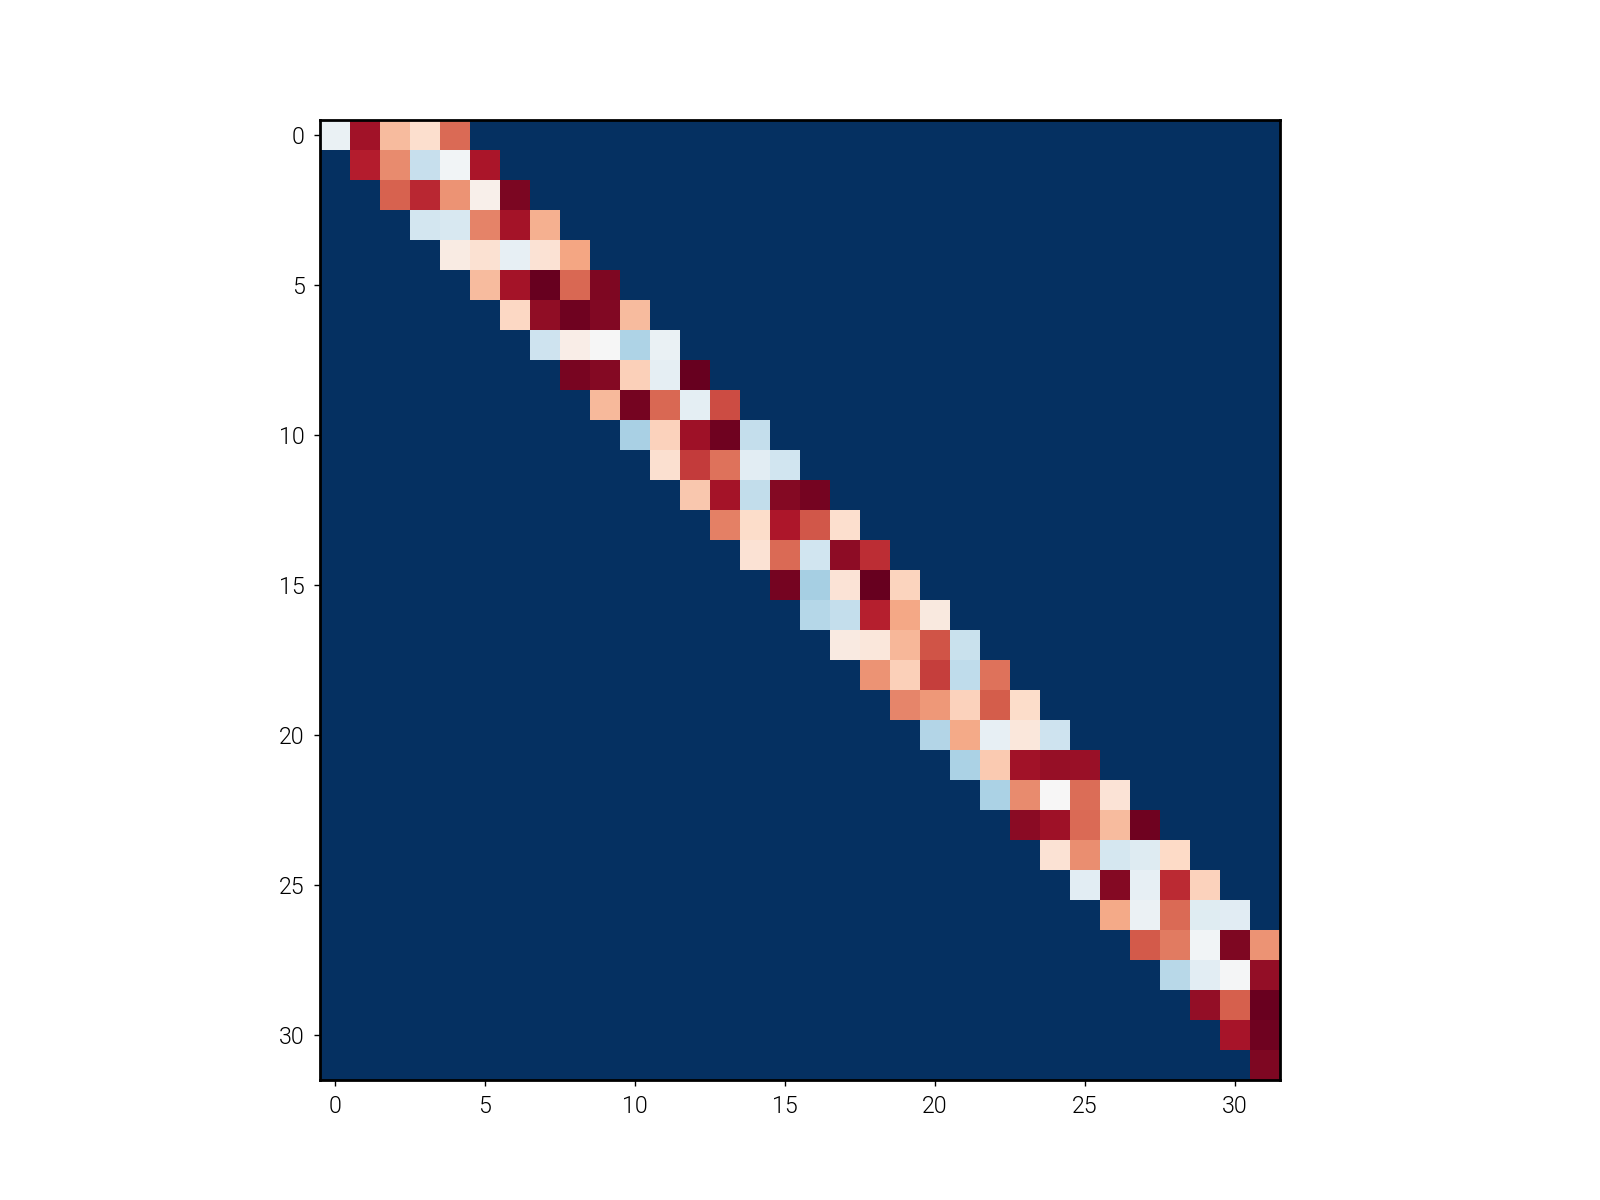

In [104]:
plt.figure()
plt.imshow(A_ban.todia().A)

In [178]:
LU.shape

(7168, 7168)